In [3]:
# Installations:
"""
pandas
openpyxl
pyarrow
"""

'\npandas\nopenpyxl\npyarrow\n'

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Variables
filename = 'time_series_data.parquet'
datetime = 'DateTime'
tagname = 'TagName'
value = 'Value'
aggr_freq_l1 = '10s'
bar_angle = 'Bar Angle'
pressure = 'Pressure'
height = 'RS4R4 Height'
col_name = [bar_angle, pressure, height]
roll_window = 10
percentiles = [25, 50, 75]

In [3]:
def reads_parquet(filename:str) -> pd.DataFrame:
    try:
        df = pd.read_parquet(filename)
        print("df.shape: ", df.shape)
        return df
    except Exception as e:
        print(f"Exceoption: {e} occurred")
        raise e

In [4]:
def drops_null(df: pd.DataFrame) -> pd.DataFrame:   
    if df.empty:
        print("Dataframe is empty")
        return None
    elif df.isnull().sum().sum() > 0:
        try:
            print("Before null removal, df.shape: ", df.shape)
            df = df.dropna() #.reset_index(drop=True)
            print("After null removal, df.shape: ", df.shape)
            return df
        except Exception as e:
            print(f"Exceoption: {e} occurred")
            raise e
    else:
        return df

def drops_duplicate(df: pd.DataFrame) -> pd.DataFrame:  
    if df.empty:
        print("Dataframe is empty")
        return None
    elif df.duplicated().sum() > 0:
        try:
            print("Before duplicate removal, df.shape: ", df.shape)
            df = df.drop_duplicates(subset=[datetime, tagname]) #.reset_index(drop=True)
            print("After duplicate removal, df.shape: ", df.shape)
            return df
        except Exception as e:
            print(f"Exceoption: {e} occurred")
            raise e
    else:
        return df

In [5]:
def check_nulls_in_col(df:pd.DataFrame) -> list:
    if not df.empty:
        return [(x,y) for x, y in zip(df.isnull().sum().keys(), df.isnull().sum()) if y != 0]
    else:
        print("pass correct dataframe")
        pass

def check_nulls_plot(df:pd.DataFrame):
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')

In [6]:
def pivots_data(df:pd.DataFrame) -> pd.DataFrame:
    try:
        print("Before pivot, df.shape: ", df.shape)
        df_pivot = df.pivot(index=datetime, columns=tagname, values=value).reset_index().copy()
        print("After pivot, df.shape: ", df_pivot.shape)
        return df_pivot
    except Exception as e:
        print(f"Exceoption: {e} occurred")
        raise e

In [7]:
def groups_data(df:pd.DataFrame, aggr_freq_l1:str) -> pd.DataFrame:
    try:
        print("Before grouping, df.shape: ", df.shape)
        df_grouped = df.groupby([pd.Grouper(key=datetime, freq=aggr_freq_l1)]).mean()
        print("After grouping, df.shape: ", df_grouped.shape)
        return df_grouped
    except Exception as e:
        print(f"Exceoption: {e} occurred")
        raise e

In [8]:
def drops_col(df:pd.DataFrame, col_name:list) -> pd.DataFrame:
    try:
        if len(col_name) == 1:
            if col_name[0] in df.columns:
                print("Before dropping columns, df.shape: ", df.shape)
                df = df.drop(columns=col_name, axis=1)
                print(f"{col_name} columns are dropped.")
                print("After dropping columns, df.shape: ", df.shape)
                return df
            else:
                print(f"{col_name[0]} not found in dataframe")
        else:
            if np.sum([True if x in df.columns else False for x in col_name]) == len(col_name):
                print("Before dropping columns, df.shape: ", df.shape)
                df = df.drop(columns=col_name, axis=1)
                print(f"{col_name} columns are dropped.")
                print("After dropping columns, df.shape: ", df.shape)
                return df
            else:
                print(f"Either 1 or more columns not found in dataframe")
    except Exception as e:
        print(e)
        raise e

In [9]:
def plots_corr(df:pd.DataFrame):
    # Visualize the correlation matrix using a heatmap
    plt.figure(figsize=(3, 1.5))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix')
    plt.show()

In [10]:
def plots_timeseries_data(df:pd.DataFrame, col_name:list, time_axis:str):
    # Loop through each column, plot its values over time
    fig, axs = plt.subplots(len(col_name), 1, figsize=(12,len(col_name)*2.5))
    for i, column in enumerate(col_name):
        df.plot(time_axis, column, ax=axs[i])
    # Adjust the spacing between the plots
    plt.subplots_adjust(hspace=0.755)
    plt.show()

In [11]:
def rolling_percentiles(series):
    return (np.percentile(series.dropna(), percentiles)).tolist()

def creates_percentile_col(df:pd.DataFrame, percentiles:list, column:str, roll_window:int) -> pd.DataFrame:
    return pd.DataFrame({f"perc_{percentiles[i]}_{column[:3]}" : df[column].rolling(window=roll_window).apply(lambda x: rolling_percentiles(x)[i], raw=False).tolist() for i in range(len(percentiles))})

def concats_percentile_data(df:pd.DataFrame, percentiles:list, col_name:list, roll_window:int) -> pd.DataFrame:
    # Iterate over the list of DataFrames and concatenate
    for col in col_name:
        df = pd.concat([df, creates_percentile_col(df, percentiles, col, roll_window)], axis=1)
    return df

df.shape:  (712070, 3)
Before null removal, df.shape:  (712070, 3)
After null removal, df.shape:  (712069, 3)


,DateTime,TagName,Value
0,2023-10-05,Pressure,60.862499
1,2023-10-05,Bar Angle,38.530838


Before pivot, df.shape:  (712069, 3)
After pivot, df.shape:  (671761, 4)
[('Bar Angle', 431443), ('Pressure', 440320), ('RS4R4 Height', 431451)]


TagName,DateTime,Bar Angle,Pressure,RS4R4 Height
0,2023-10-05 00:00:00.000,38.530838,60.862499,0.37324
1,2023-10-05 00:00:00.010,NaN,60.937500,NaN


Before grouping, df.shape:  (671761, 4)
After grouping, df.shape:  (25904, 3)
[('Pressure', 4)]


TagName,Bar Angle,Pressure,RS4R4 Height
DateTime,,,
2023-10-05 00:00:00,38.479168,61.619999,0.369833
2023-10-05 00:00:10,38.549345,62.103750,0.369945


Before null removal, df.shape:  (25904, 3)
After null removal, df.shape:  (25900, 3)


TagName,DateTime,Bar Angle,Pressure,RS4R4 Height
0,2023-10-05 00:00:00,38.479168,61.619999,0.369833
1,2023-10-05 00:00:10,38.549345,62.103750,0.369945


Before dropping columns, df.shape:  (25900, 4)
['DateTime'] columns are dropped.
After dropping columns, df.shape:  (25900, 3)


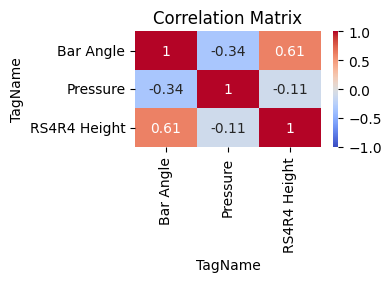

In [14]:
df = reads_parquet(filename)
df = drops_null(df)
df = drops_duplicate(df)
display(df.head(2))

df_pivot = pivots_data(df)
print(check_nulls_in_col(df_pivot))
display(df_pivot.head(2))

df_grouped = groups_data(df_pivot, aggr_freq_l1)
print(check_nulls_in_col(df_grouped))
display(df_grouped.head(2))

df_grouped = drops_null(df_grouped)
df_grouped = df_grouped.reset_index().sort_values(by=datetime, ascending=True)
display(df_grouped.head(2))

plots_corr(drops_col(df_grouped, [datetime]))

### Feature Engineering 1: Add Descriptives

In [15]:
rolling_agg = df_grouped[col_name].rolling(roll_window).aggregate(['max', 'min', 'mean', 'std']).copy()
# Rename the columns # ["_".join(col.split("_")[1][1:-1].replace("'","").replace(",","").lower().split(" ")) for col in rolling_agg.columns]
rolling_agg.columns = [" ".join(col) for col in rolling_agg.columns]

agg_final_df = pd.concat([df_grouped, rolling_agg], axis=1)
print(agg_final_df.shape)
agg_final_df.loc[7:10]

(25900, 16)


,DateTime,Bar Angle,Pressure,RS4R4 Height,Bar Angle max,Bar Angle min,Bar Angle mean,Bar Angle std,Pressure max,Pressure min,Pressure mean,Pressure std,RS4R4 Height max,RS4R4 Height min,RS4R4 Height mean,RS4R4 Height std
7,2023-10-05 00:01:10,38.752091,61.904167,0.367759,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2023-10-05 00:01:20,38.154352,62.120834,0.371981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2023-10-05 00:01:30,38.266919,61.050001,0.368838,38.903589,38.154352,38.564612,0.251584,62.996249,60.966665,61.75174,0.657827,0.371981,0.365157,0.369024,0.001793
10,2023-10-05 00:01:40,38.239905,60.937500,0.366727,38.903589,38.154352,38.540686,0.271223,62.996249,60.937500,61.68349,0.706610,0.371981,0.365157,0.368713,0.001903


### Feature Engineering 2: Add Percentiles

In [135]:
perc_final_df = concats_percentile_data(df_grouped, percentiles, col_name, roll_window)
print(perc_final_df.shape)
perc_final_df.loc[7:10]

(25900, 13)


,DateTime,Bar Angle,Pressure,RS4R4 Height,perc_25_Bar,perc_50_Bar,perc_75_Bar,perc_25_Pre,perc_50_Pre,perc_75_Pre,perc_25_RS4,perc_50_RS4,perc_75_RS4
7,2023-10-05 00:01:10,38.752091,61.904167,0.367759,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2023-10-05 00:01:20,38.154352,62.120834,0.371981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2023-10-05 00:01:30,38.266919,61.050001,0.368838,38.461241,38.514257,38.744156,61.158334,61.762083,62.116563,0.368541,0.368977,0.369917
10,2023-10-05 00:01:40,38.239905,60.937500,0.366727,38.315278,38.506618,38.744156,61.004298,61.693750,62.116563,0.367930,0.368840,0.369737


### Feature Engineering 3: Date Based

In [42]:
def creates_date_features(df:pd.DataFrame, date_column:str) -> pd.DataFrame:
    try:
        df['month'] = df[date_column].dt.month
        df['day'] = df[date_column].dt.day
        df['shift'] = np.divide(df[date_column].dt.strftime('%H').astype(int),8).astype(int)
        df['hour'] = df[date_column].dt.strftime('%H').astype(int)
        df['day_of_week'] = df[date_column].dt.day_of_week
        df['week'] = df[date_column].dt.strftime('%U').astype(int)
        return df
    except Exception as e:
        print(e)
        return None

In [43]:
dates_feature_df = creates_date_features(df_grouped, datetime)
print(dates_feature_df.shape)
dates_feature_df.loc[7:10]

(25900, 10)


TagName,DateTime,Bar Angle,Pressure,RS4R4 Height,month,day,shift,hour,day_of_week,week
7,2023-10-05 00:01:10,38.752091,61.904167,0.367759,10,5,0,0,3,40
8,2023-10-05 00:01:20,38.154352,62.120834,0.371981,10,5,0,0,3,40
9,2023-10-05 00:01:30,38.266919,61.050001,0.368838,10,5,0,0,3,40
10,2023-10-05 00:01:40,38.239905,60.937500,0.366727,10,5,0,0,3,40


### Feature Engineering 4: Offset (Leading & Lagging)

In [13]:
def creates_lead_lag_feature(df:pd.DataFrame, shifts:np.array) -> pd.DataFrame:
    try:
        # Use a nested dictionary comprehension to create name: value pairs, one pair per shift and column
        shifted_data = {
            f'{col}_lag_{day_shift}_day': df[col].shift(day_shift) 
            for col in df.columns 
            for day_shift in shifts
        }
        # Convert into a DataFrame for subsequent use
        shifted_df = pd.DataFrame(shifted_data, index=df.index)
        # Optionally, add the original columns back to the DataFrame
        for col in df.columns:
            shifted_df[col] = df[col]
        return shifted_df
    except Exception as e:
        print(e)
        raise e

In [17]:
# These are the "time lags"
shifts = np.array([-5, 5]) # np.arange(5, 10).astype(int)
final_df = creates_lead_lag_feature(df_grouped[col_name], shifts)
final_df = pd.concat([df_grouped, final_df], axis=1)
print(final_df.shape)
# final_df.loc[7:10]
final_df.head(10)

(25900, 13)


,DateTime,Bar Angle,Pressure,RS4R4 Height,Bar Angle_lag_-5_day,Bar Angle_lag_5_day,Pressure_lag_-5_day,Pressure_lag_5_day,RS4R4 Height_lag_-5_day,RS4R4 Height_lag_5_day,Bar Angle,Pressure,RS4R4 Height
0,2023-10-05 00:00:00,38.479168,61.619999,0.369833,38.460358,NaN,62.283334,NaN,0.365157,NaN,38.479168,61.619999,0.369833
1,2023-10-05 00:00:10,38.549345,62.103750,0.369945,38.720350,NaN,61.483333,NaN,0.369112,NaN,38.549345,62.103750,0.369945
2,2023-10-05 00:00:20,38.903589,60.966665,0.368842,38.752091,NaN,61.904167,NaN,0.367759,NaN,38.903589,60.966665,0.368842
3,2023-10-05 00:00:30,38.896061,60.989064,0.368442,38.154352,NaN,62.120834,NaN,0.371981,NaN,38.896061,60.989064,0.368442
4,2023-10-05 00:00:40,38.463891,62.996249,0.370329,38.266919,NaN,61.050001,NaN,0.368838,NaN,38.463891,62.996249,0.370329
5,2023-10-05 00:00:50,38.460358,62.283334,0.365157,38.239905,38.479168,60.937500,61.619999,0.366727,0.369833,38.460358,62.283334,0.365157
6,2023-10-05 00:01:00,38.720350,61.483333,0.369112,38.526945,38.549345,62.883750,62.103750,0.369605,0.369945,38.720350,61.483333,0.369112
7,2023-10-05 00:01:10,38.752091,61.904167,0.367759,39.064111,38.903589,63.219642,60.966665,0.370593,0.368842,38.752091,61.904167,0.367759
8,2023-10-05 00:01:20,38.154352,62.120834,0.371981,39.047231,38.896061,62.357812,60.989064,0.368600,0.368442,38.154352,62.120834,0.371981
9,2023-10-05 00:01:30,38.266919,61.050001,0.368838,39.158625,38.463891,62.493751,62.996249,0.368883,0.370329,38.266919,61.050001,0.368838


### Feature Engineering 5: 

In [1]:
# # Import TimeSeriesSplit
# from sklearn.model_selection import TimeSeriesSplit
# # Create time-series cross-validation object
# cv = TimeSeriesSplit(n_splits=10)
# # Iterate through CV splits
# fig, ax = plt.subplots()
# for ii, (tr, tt) in enumerate(cv.split(X, y)):
#     # Plot the training data on each iteration, to see the behavior of the CV
#     ax.plot(tr, ii + y[tr])
# ax.set(title='Training data on each CV iteration', ylabel='CV iteration')
# plt.show()

In [ ]:
# plots_timeseries_data(df_grouped, col_name, datetime)
# df_grouped.boxplot(figsize=(8,2))

In [19]:
# import plotly.graph_objects as go

# fig = go.Figure()
# for col in col_name:
#   fig.add_trace(go.Box(y=df_grouped[col].values, name=df_grouped[col].name, boxpoints='all'))
# fig.show()

# from functools import partial
# perc_funcs = [partial(np.percentile, q=ii) for ii in [25, 75]]
# percentiles = [i_func(drops_col(df_grouped, [datetime])) for i_func in perc_funcs]
# percentiles